# Josh Zelonis - DEFCON Submission Supplement
I've taken some time to sample out the highlights and walk the review board through a "lite" version of the code I'll be presenting/releasing if given the opportunity. For now I'm calling it 'Falco' because I started off using the rockyou.txt dataset before hunting down combos and got an earworm for their 1985 hit, "Rock Me Amadeus".

I've been using the 2021 Twitter leak to collect sample sets of 10k users due to an assumption that these are probably real people who I'll have collisions with my combo lists. The parquet file I'm importing is a dataframe that contains all the heavy computation pieces for this to make assembling this document a bit easier on me.

In [1]:
import polars as pl
import os

SAMPLE = './data/sample-03.parquet'
sample = pl.read_parquet(os.path.expanduser(SAMPLE))

print(sample.shape)
sample.schema

(10000, 8)


OrderedDict([('Email', String),
             ('Name', String),
             ('ScreenName', String),
             ('Followers', Int64),
             ('Created At', Int64),
             ('Passwords', List(String)),
             ('Instances', UInt32),
             ('Similarity', Float64)])

I've sorted and indexed over 2.5B unique combos from about 1TB of combos and stealers doing my best to clean them with scripts I'll be releasing with the talk as well.

Here's a quick demonstration of how I'm populating the Passwords column and a test against my own email address. 

In [2]:
import subprocess


SPLITS_PATH = '/Users/josh/breach/splits/'
idx = {}
with open(SPLITS_PATH + 'index.idx', "r", encoding='latin-1') as f:
    for line in f:
        k,v = line.strip().split(':', maxsplit=1)
        idx.update({k:v})


def lookupIndex(c):
    for k,v in idx.items():
        if c < v:
            return k


def getPasswords(email):
    ret = []
    e = str(email).lower()
    cmd = ['/usr/bin/grep', f'^{e}', SPLITS_PATH+lookupIndex(e)]
    lines = subprocess.run(cmd, capture_output=True, text=True).stdout.rsplit()

    for line in lines:
        try:
            ret.append(line.split(':',1)[1])
        except IndexError:
            continue
    return ret


getPasswords('<redacted>@gmail.com')

['b0bface!', 'yqw46gw9']

Note that I'm intentionally not showing names/emails/etc in this supplement, but here's a brief description of the following columns:
* Passwords - This is a list of strings representing passwords idenfitied as being associated with the email that is essentially my private key index on this dataframe.
* Instances - Just a count of the number of unique passwords we have for each row.
* Similarity - This is leveraging a transformer from HuggingFace to calculate the average similarity across every combination of Passwords in a row. Note that one password is treated as an identity and zero is nothing.

In [3]:
sample.select(
    pl.col(['Passwords', 'Instances', 'Similarity'])
)

Passwords,Instances,Similarity
list[str],u32,f64
"[""justedebout""]",1,1.0
"[""romer"", ""romero"", ""romero106""]",3,0.375997
[],0,0.0
"[""123456ru""]",1,1.0
"[""Coconut26*"", ""coconut26*"", ""pineapple26""]",3,0.614015
…,…,…
"[""chelseasmi"", ""chelseasmile""]",2,0.87876
[],0,0.0
"[""heart8""]",1,1.0


Quick univariate analysis on the number of times each user has been compromised with unique credentials in my data. Basically, we end up with just short of 60% of users showing up in my data less than twice and one soul getting compromised over 120 times which admittedly could be noise but it's not statistically significant whether or not it is. 

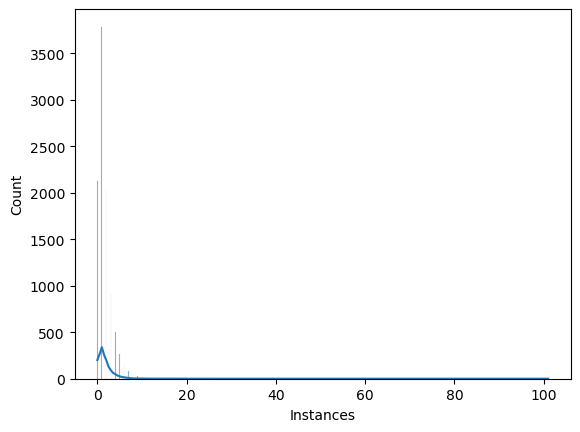

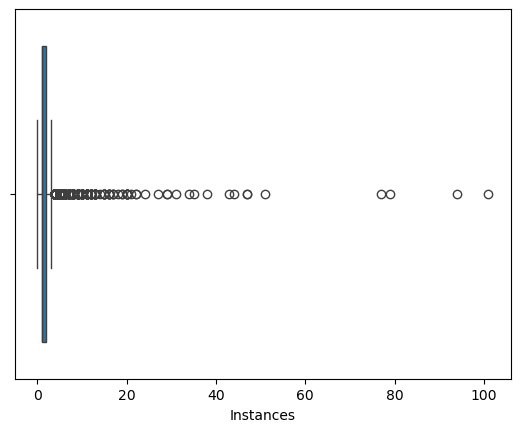

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.histplot(data=sample.to_pandas(), x='Instances', kde=True)
plt.show()
sns.boxplot(data=sample.to_pandas(), x='Instances')
plt.show()

Resampling to remove users who have been compromised fewer than 2 times as this is the floor for our ability to split out a test and train set.

We will then go through the process of creating that test and train set, with the test set being converted from a list[str] to a list.

Note that the shape of this goes from 10k rows to 4093 during this step.

In [5]:
resample = sample.with_columns(
    pl.col('*')
).filter(pl.col('Instances')>1)

# Randomly pick one of the passwords as our test
resample = resample.with_columns(
    pl.col('Passwords')
    .list.sample(n=1, seed=0xb0bface)
    .alias('Test')
)

# Take the difference of the test and the password lists to create our "train" list
resample = resample.with_columns(
    pl.col('Passwords')
    .list.set_difference('Test')
    .alias('Train')
)

# Convert the test value from a list[str] with a single element to a str (probably a better way to do this but *shrug*)
resample = resample.with_columns(
    pl.col('Test')
    .list.join('')
    .alias('Test')
)

# Simplify code moving forward since I'm cutting/pasting from a much larger code base for this submission.
sample = resample

# Show the train/test split. Note the rows are 4093 of the initial 10k
sample.select(
    pl.col(['Passwords', 'Instances', 'Similarity', 'Train', 'Test'])
)

Passwords,Instances,Similarity,Train,Test
list[str],u32,f64,list[str],str
"[""romer"", ""romero"", ""romero106""]",3,0.375997,"[""romer"", ""romero""]","""romero106"""
"[""Coconut26*"", ""coconut26*"", ""pineapple26""]",3,0.614015,"[""Coconut26*"", ""coconut26*""]","""pineapple26"""
"[""123"", ""steph1995""]",2,0.469135,"[""123""]","""steph1995"""
"[""Indokingpop"", ""tchophie""]",2,0.370441,"[""Indokingpop""]","""tchophie"""
"[""7777"", ""Orangee1"", … ""orangee1""]",4,0.600454,"[""7777"", ""Orangee1"", ""Orangee1!""]","""orangee1"""
…,…,…,…,…
"[""6v8pq7"", ""Newports1"", … ""qwerty""]",5,0.189279,"[""6v8pq7"", ""Newports1"", … ""newports1""]","""qwerty"""
"[""Chocolate11"", ""Chocolate11!"", … ""chocolatetaco1!""]",7,0.742572,"[""Chocolate11"", ""Chocolate11!"", … ""chocolatetaco1!""]","""chocolatetaco1…"
"[""chelseasmi"", ""chelseasmile""]",2,0.87876,"[""chelseasmi""]","""chelseasmile"""


Sample code using transformers to compare the similarity across passwords which is helpful for targeting. There's nuance here because one value will have an outsized impact on the metric for fewer than 5 passwords due to the number of combinations. Experimentally, accounts with over 0.8 similarity are ripe for abuse.

In [6]:
from sentence_transformers import SentenceTransformer, util
import numpy as np
import statistics


def calculateSimilarity(plist):
    if len(plist)<2:
        return len(plist)   # one password is an identity, zero is nothing
    
    model = SentenceTransformer('sentence-transformers/all-MiniLM-l6-v2')
    embeddings = []
    for p in plist:
        embeddings.append(model.encode(p))


    arr = np.array([])
    while len(embeddings)>1:
        source = embeddings.pop()
        for embedding in embeddings:
            arr = np.append(arr, [float(util.pytorch_cos_sim(source, embedding)[0][0])])

    return statistics.median(arr)

print(calculateSimilarity(['123456', 'Francesca16', 'francesca', 'francesca16']))
print(calculateSimilarity(['123456', 'Francesca16', 'francesca', 'francesca16', 'francesca17']))
print(calculateSimilarity(['Francesca16', 'francesca', 'francesca16', 'francesca17']))

0.5603891685605049
0.8896716833114624
0.9253764450550079


The Histogram for Similarity gives the idea that approximately 25% of users are using similar passwords across multiple breaches.

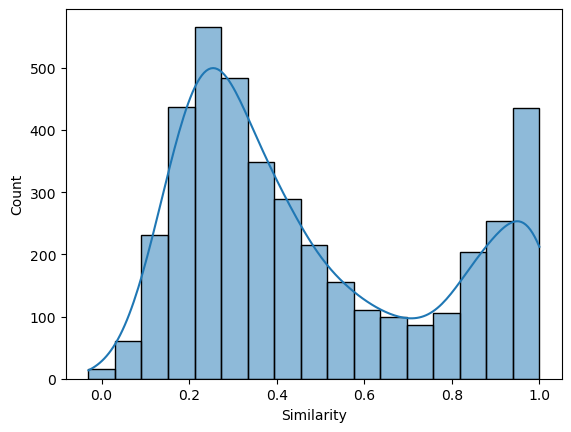

In [7]:
sns.histplot(data=sample.select(pl.col('Similarity')).to_pandas(), x='Similarity',  kde=True)
plt.show()

I have a number of techniques that I've described in the abstract and have code to support, including leveraging ChatGPT 3.5 to help tokenize these passwords and feeding that data back into zxcvbn to get token literals for building a Spike-like grammar/fuzzer that is tailored to individual users. I'll touch on that later, but I'm going to start by demonstrating a simple technique that gets me 20% cracking efficacy with a median of 30 guesses for the 4093 users I have more than one credential pair for in the original sample of 10k. 

In [9]:
import re
# Top 8 specials by counting trailing character on all passwords in this set
SPECIALS = '!$.@#=*?'

def rstripSpecials(arr):
    ret = []
    for val in arr:
        if val is None: continue
        if val[-1] in ')|]"¡%.+~!$^>_/@:?&=#*-':
            ret.append(str(val[:-1]))
        else:
            ret.append(str(val))

    return ret


def invertCapitalization(arr):
    ret = []
    for val in arr:
        if re.match('^[A-Z]', val[0]):
            guess = val[0].lower() + val[1:]
        elif re.match('^[a-z]', val[0]):
            guess = val[0].upper() + val[1:]
        else:
            continue

        if guess not in arr:
            ret.append(guess)

    return ret


def tokenGuesses(token):
    ret = []
    rstrip = rstripSpecials(token)
    for val in rstrip:
        if val not in token:
            ret.append(val)
        for s in SPECIALS:
            guess = val + s
            if guess not in token:
                ret.append(guess)
    caps = invertCapitalization(token + ret)

    return list(set(ret + caps))

tokenGuesses(['bob!', 'bob:'])

['bob#',
 'bob.',
 'bob?',
 'Bob!',
 'Bob.',
 'Bob=',
 'Bob',
 'Bob?',
 'bob@',
 'Bob$',
 'bob*',
 'Bob*',
 'bob=',
 'bob',
 'bob$',
 'Bob#',
 'Bob:',
 'Bob@']

This next cell does three things:
* Runs the 'Train' set through tokenGuesses that creates unique password guesses based on a token that has been stripped of any special trailing character and performed a number of operations to create a set of 'Guesses' such as toggling the capitalization of the first character of the token and iterating through a few common symbols. Each of these 'Guesses' is guaranteed to be both unique and not part of the 'Train' set because that would just be credential stuffing.
* Tests to see if the 'Test' value is in the 'Guesses' and outputs the truth value for this into a 'Success' column.
* Adds the number of True 'Success' values and divides by the number of rows in this set (4093) to give us the percent of successfully guessed credentials (~21%)

In [10]:
sample = sample.with_columns(
    pl.struct(['Train'])
    .map_elements(lambda col: tokenGuesses(col['Train']), return_dtype=list[str])
    .alias('Guesses')
)

sample = sample.with_columns(
    pl.struct(['Test','Guesses'])
    .map_elements(lambda row: (row['Test'] in row['Guesses']) if (row['Guesses'] is not None) else False, return_dtype=bool)
    .alias('Success')
)

sample.select(
    pl.col('Success')
    .sum()
)/sample.shape[0]

Success
f64
0.217444


Ok, so we've shown this single token guessing strategy works fairly well (21.7%) against the set of users we have more than one compromised credential for, which is 8.88% of the original 10k number. For context, Cloudflare estimates credential stuffing attacks work at a rate of 1-3% so we're essentially doubling or tripling the effectiveness of combo lists as a data set by doing something smarter than just seeing if they work. How about the number of guesses it takes to get this level of accuracy?

On average, fewer than 35 guesses with the median right at 30 due to the skew nature of the number of 'Instances'.

In [11]:
sample.with_columns(
    pl.col('Guesses')
    .list.len()
    .alias('len')
).select(
    pl.col('*')
).filter(
    pl.col('Success') == True
).select(
    pl.median('len')
)

len
f64
30.0


Now that we've shown the effectiveness of this technique for single tokens, let's explore how I'm leveraging LLM and other tools to deliver some pretty exciting outcomes. 

Starting with a simple ChatGPT parsing prompt and an XKCD reference.

In [16]:
import os
from openai import OpenAI
OPENAI_KEY_PATH = '~/.openai/key'

with open(os.path.expanduser(OPENAI_KEY_PATH), 'r') as f:
    client = OpenAI(api_key = f.read().rstrip('\n'))

import json

def OpenAITokenizer(p):
  messages = [
    {
      "role": "system", 
      "content": 'You are a helpful assistant who will respond in json, but only with an array of entities. also, if the word happens to be a name, specify that. For example, if I ask you to parse the string "b0bface77" you will respond with the json key "grammar" that is an array ["name", "word", "digits"] and a matching "tokens" array ["bob", "face", "77"], also include a binary setting "l33t" that is true if any of the words were in l33tspeak and false otherwise. If something looks parses into a series of letters that aren\'t a word you\'re familiar with, classify them as "letters". for consistency, call "special characters" as "symbols" and use a greedy algorithm for combining them. make sure not to leave out any symbols when outputting tokens'
    },
    {
      'role': "user",
      'content':f'Parse the string "{p}" into a grammar, after translating from l33t speak if necessary. respond in json'
    }
  ]

  response = completion = client.chat.completions.create(
    model="gpt-3.5-turbo",
    messages=messages,
    response_format= { "type":"json_object" }
  )

  return json.loads(completion.choices[0].message.content)['tokens']

OpenAITokenizer('Tr0ub4d0ur64')


['troubadour', '64']

Ok, so we want to use LLM because it has the biggest dictionary one can imagine for parsing out tokens like this. But the challenge is that this isn't necessarily what we want to be brute forcing with. Instead, I feed this very small dictionary back into a program Dropbox published a decade ago to help gage password strength.

In [13]:
from zxcvbn import zxcvbn

zxcvbn('Tr0ub4d0ur64', ['troubadour', '64'])

{'password': 'Tr0ub4d0ur64',
 'guesses': Decimal('15000'),
 'guesses_log10': 4.176091259055681,
 'sequence': [{'pattern': 'dictionary',
   'i': 0,
   'j': 9,
   'token': 'Tr0ub4d0ur',
   'matched_word': 'troubadour',
   'rank': 1,
   'dictionary_name': 'user_inputs',
   'reversed': False,
   'l33t': True,
   'sub': {'4': 'a', '0': 'o'},
   'sub_display': '4 -> a, 0 -> o',
   'base_guesses': 1,
   'uppercase_variations': 2,
   'l33t_variations': 4,
   'guesses': 50,
   'guesses_log10': 1.6989700043360185},
  {'pattern': 'dictionary',
   'i': 10,
   'j': 11,
   'token': '64',
   'matched_word': '64',
   'rank': 2,
   'dictionary_name': 'user_inputs',
   'reversed': False,
   'l33t': False,
   'base_guesses': 2,
   'uppercase_variations': 1,
   'l33t_variations': 1,
   'guesses': 50,
   'guesses_log10': 1.6989700043360185}],
 'calc_time': datetime.timedelta(microseconds=784),
 'crack_times_seconds': {'online_throttling_100_per_hour': Decimal('540000.0000000000299760216649'),
  'online_no_

So now we have the token literals for this password ['Tr0ub4d0ur', '64'] and don't have to worry about translating in and out of l33tspeak, the assumption is if you're the kind of person who is going to use l33tspeak, it's going to show up in your token literals so we don't even care how you go about this. The truth is that zxcvbn would have sufficed for parsing this without the help from ChatGPT, but there's one more outcome we get from using ChatGPT, and that's that when it fucks up, it's a really good indicator that there's a lot of entropy in the password.

In [14]:
OpenAITokenizer('b868d57c3850e82290aad941ba80f1a6ed329a95')

['b',
 '868',
 'd',
 '57',
 'c',
 '3850',
 'e',
 '822',
 '90',
 'aad',
 '941',
 'ba',
 '80',
 'f',
 '1',
 'a',
 '6',
 'ed',
 '329',
 'a',
 '95']

So I've built an entropy metric based on this to help filter out high entropy results from hashes or possibly password managers. I'm not currently filtering based on this, but I think it's valuable enough to discuss and help other hackers understand that sometimes when GenAI isn't giving you what you want, it's giving you something else that may be of value.

The output of this line is a summary of rows where the 'Entropy' metric is over 0.75 to demonstrate how effective this surprising metric ended up being for finding high entropy strings.

In [15]:
import polars as pl
import os

PASSWORDS = './data/passwords-zxcvbn.parquet'
pw = pl.read_parquet(os.path.expanduser(PASSWORDS))

pw.select(pl.col('*')).filter(pl.col('Entropy')>0.75)

Password,Tokens,Entropy,Literals
str,list[str],f64,list[str]
"""6f6892""","[""6"", ""f"", … ""2""]",1.0,"[""6f6892""]"
"""946506146gm""","[""9"", ""4"", … ""gm""]",0.818182,"[""94"", ""650614"", ""6gm""]"
"""7sd2fs""","[""7"", ""s"", … ""s""]",1.0,"[""7sd2fs""]"
"""R5swbr""","[""r"", ""5"", … ""r""]",0.833333,"[""R5swbr""]"
"""e01ENX02Tm9MQT…","[""e"", ""01"", … ""0""]",0.769231,"[""e01ENX02Tm9MQTJHaGV6emZBV0gzbzFIcWZRP"", ""T0""]"
…,…,…,…
"""0n3l0v3""","[""0"", ""n"", … ""v""]",0.857143,"[""0n3l0v3""]"
"""dDLXYO""","[""d"", ""d"", … ""o""]",1.0,"[""dDLXYO""]"
"""q7w9qj""","[""q"", ""7"", … ""j""]",0.833333,"[""q7w9qj""]"


I want to wrap up by saying that I appreciate your time and consideration for this talk.
